# Лабораторная работа №1

In [1]:
# Loading extension for reloading editable packages (pip install -e .)
%load_ext autoreload

In [2]:
# Reloading editable packages.
%autoreload
# from lab1.main import get_results

Вариант для задания №3:
1. Номер группы + 15 = 2 + 15 = 17
2. Номер варианта + 56 = 14 + 56 = 70
3. ИУ5 (Номер варианта + 21) = 14 + 21 = 35

In [3]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from numpy.typing import ArrayLike
from PIL import Image
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset

%matplotlib inline

## Часть 1. Задача регрессии по теореме универсальной аппроксимации, ручное дифференцирование
Генерация выборки и инициализация параметров нейронной сети

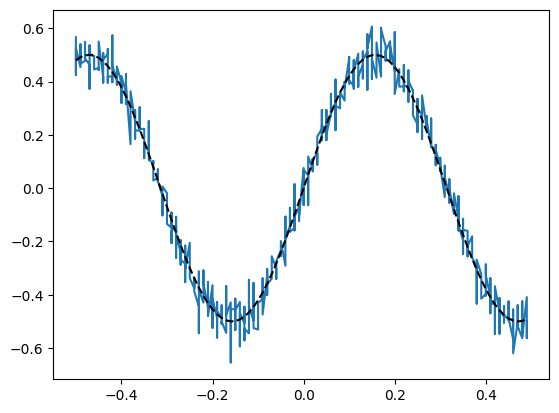

In [4]:
from operator import itemgetter  # noqa

X = (np.arange(100) / 100 - 0.5).repeat(5)
# Наша функция, которую мы пытаемся получить в ходе апроксимации.
# y = 1 / (1 + np.exp(-10 * X))  # Исходная.
y = np.sin(X * 10) / 2
yn = np.random.normal(scale=0.05, size=y.size) + y

plt.plot(X, yn)
plt.plot(X, y, linestyle="--", c="k")
################################################

HIDDEN_SIZE = 64


# size = 1 for regression, size = number of classes for classification.
def np_to_tensor(arr: ArrayLike, size=1):
    return torch.Tensor(arr.reshape(-1, size))


tensor_X = np_to_tensor(X)
tensor_y = np_to_tensor(yn)


# Инициализация весов MLP с одним скрытым слоём
def init_neural_network(hidden_size=HIDDEN_SIZE):
    weights1 = (torch.rand(1, hidden_size) - 0.5) / 10
    bias1 = torch.zeros(hidden_size)

    weights2 = (torch.rand(hidden_size, 1) - 0.5) / 10
    bias2 = torch.zeros(1)

    return {"weights1": weights1, "bias1": bias1, "weights2": weights2, "bias2": bias2}


weights1, bias1, weights2, bias2 = itemgetter("weights1", "bias1", "weights2", "bias2")(
    init_neural_network()
)

### Обучение нейронной сети задачи регрессии

0.00476843


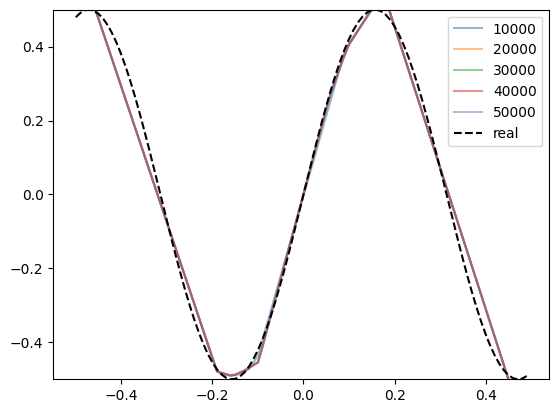

In [5]:
# Определяем функцию нелинйности
def relu(x: torch.Tensor):
    return torch.maximum(x, torch.Tensor([0]))


# Прямой проход
def forward(x: torch.Tensor) -> torch.Tensor:
    return (weights2.t() * relu((weights1 * x) + bias1)).sum(
        axis=-1, keepdims=True
    ) + bias2


def loss(y: torch.Tensor, y_: torch.Tensor) -> torch.Tensor:
    return ((y - y_) ** 2).sum(axis=-1)


# обратный проход
def backward(X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor):
    # производная функции потерь по y_pred
    dL = 2 * (y_pred - y)
    # значения нейронов скрытго слоя до применения активации
    Ax = (weights1 * X) + bias1
    # значения нейронов скрытого слоя после применения активации
    A = relu(Ax)
    # производная функции потерь по weight_2
    dW2 = torch.mm(A.t(), dL)
    # производная функции потерь по bias_2
    db2 = dL.sum(axis=0)
    # производная функции потерь по значениям скрытого слоя после активации
    dA = torch.mm(dL, weights2.t())
    # производная функции потерь по значениям скрытого слоя до активации
    dA[Ax <= 0] = 0
    # производная функции потерь по weight_1
    dW1 = torch.mm(X.t(), dA)
    # производная функции потерь по bias_1
    db1 = dA.sum(axis=0)
    # print(dW.shape, db.shape, dW2.shape, db2.shape)

    return {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}


def optimize(params, grads, lr=0.001):
    # градиентный спуск по всей обучающей выборке
    W1, b1, W2, b2 = params
    W1 -= lr * grads["dW1"]
    W2 -= lr * grads["dW2"]
    b1 -= lr * grads["db1"]
    b2 -= lr * grads["db2"]

    return {"W1": W1, "b1": b1, "W2": W2, "b2": b2}


# 50 тысяч итераций градиентного спуска == 50 тысяч эпох
for i in range(50000):
    output = forward(tensor_X)
    cur_loss = loss(output, tensor_y)
    grads = backward(tensor_X, tensor_y, output)
    params = [weights1, bias1, weights2, bias2]
    optimized_params = optimize(params, grads, 1e-4)
    weights1, bias1, weights2, bias2 = itemgetter("W1", "b1", "W2", "b2")(
        optimized_params
    )

    if (i + 1) % 10000 == 0:
        plt.plot(X, output.numpy(), label=str(i + 1), alpha=0.5)

plt.plot(X, y, linestyle="--", c="k", label="real")
plt.legend()
plt.ylim(y.min(), y.max())
print(cur_loss.numpy().mean())

## Часть 2. Бинарная классификация с помощью автодиффиренцирования PyTorch
Генерация выборки и инициализация параметров нейронной сети

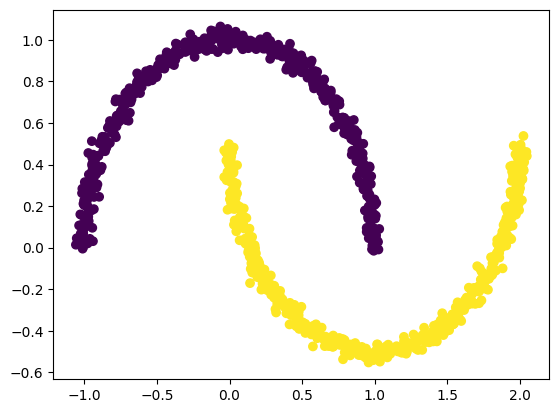

In [17]:
from sklearn.datasets import make_circles, make_moons  # noqa

# Данные, которые стараемся классифицировать:
# Исходная функция:
# X = np.random.randint(2, size=(1000, 2))
# y = (X[:, 0] + X[:, 1]) % 2  # XOR
# X = X + np.random.normal(0, scale=0.1, size=X.shape)

# Кольца, вложенные друг в друга.
# X, y = make_circles(n_samples=1000, noise=0.025)

# Вложенные друг в друга месяцы.
X, y = make_moons(n_samples=1000, noise=0.025)

plt.scatter(X[:, 0], X[:, 1], c=y)
####################################################
tensor_X = np_to_tensor(X, size=2)
tensor_y = np_to_tensor(y)

HIDDEN_SIZE = 48


# Инициализация весов MLP с одним скрытым слоём
def init_neural_network(hidden_size=HIDDEN_SIZE):
    weights1 = ((torch.rand(2, hidden_size) - 0.5) / 10).detach().requires_grad_(True)
    bias1 = torch.zeros(hidden_size, requires_grad=True)

    weights2 = ((torch.rand(hidden_size, 1) - 0.5) / 10).detach().requires_grad_(True)
    bias2 = torch.zeros(1, requires_grad=True)

    return {"weights1": weights1, "bias1": bias1, "weights2": weights2, "bias2": bias2}


weights1, bias1, weights2, bias2 = itemgetter("weights1", "bias1", "weights2", "bias2")(
    init_neural_network()
)

### Обучение нейронной сети задачи классификации

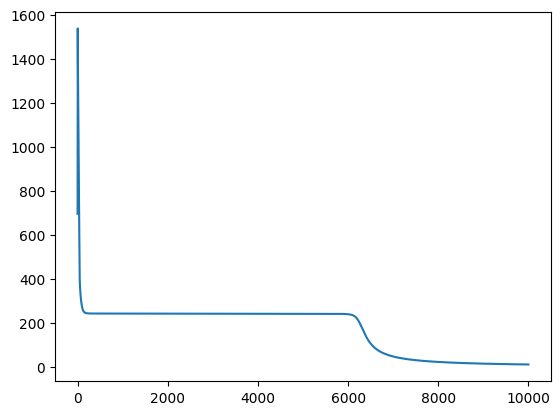

In [18]:
# Определяем функцию нелинейности
def sigmoid(x: torch.Tensor):
    return 1 / (1 + torch.exp(-x))


# Прямой проход
def forward(x: torch.Tensor):
    hidden = torch.mm(x, weights1) + bias1
    hidden_nonlin = sigmoid(hidden)
    output = (weights2.t() * hidden_nonlin).sum(axis=-1, keepdims=True) + bias2

    return sigmoid(output)


# Logloss
def loss(y_true: torch.Tensor, y_pred: torch.Tensor):
    return (
        -1 * (y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred)).sum()
    )


# lr - шаг обучения
def model(learning_rate=1e-3, iterations=10_000):
    params = [weights1, bias1, weights2, bias2]
    losses = []
    for _ in range(iterations):
        output = forward(tensor_X)
        lossval = loss(tensor_y, output)
        lossval.backward()  # тут включается в работу autograd
        for w in params:
            with torch.no_grad():
                w -= w.grad * learning_rate  # обновляем веса
            w.grad.zero_()  # зануляем градиенты, чтобы не накапливались за итерации
        losses.append(lossval.item())

    return {'losses': losses, 'output': output}


learning_results = model()
# выводим историю функции потерь по итерациям
plt.plot(learning_results['losses'])

### Проверка результатов обучения

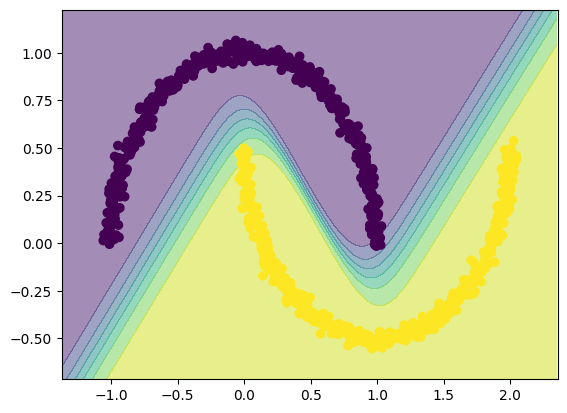

In [19]:
def plot_classification_results(data: torch.Tensor):
    x_coordinates = data[:, 0]
    y_coordinates = data[:, 1]
    x_coordinates_diff = x_coordinates.max() - x_coordinates.min()
    y_coordinates_diff = y_coordinates.max() - y_coordinates.min()
    left_boundary = x_coordinates.min() - 0.1 * x_coordinates_diff
    right_boundary = x_coordinates.max() + 0.1 * x_coordinates_diff
    bottom_boundary = y_coordinates.min() - 0.1 * y_coordinates_diff
    top_boundary = y_coordinates.max() + 0.1 * y_coordinates_diff

    grid = np.arange(left_boundary, right_boundary, 0.01)
    grid_width = grid.size
    surface = []
    # создаем точки по сетке
    for x1 in grid:
        for x2 in grid:
            surface.append((x1, x2))
    surface = np.array(surface)
    # получаем предсказания для всех точек плоскости, модель по уже полученным
    # весам пытается определить, какому классу принадлежит точка.
    with torch.no_grad():
        Z = forward(torch.Tensor(surface)).detach().numpy()
    # меняем форму в виде двухмерного массива
    Z = Z.reshape(grid_width, grid_width)
    xx = surface[:, 0].reshape(grid_width, grid_width)
    yy = surface[:, 1].reshape(grid_width, grid_width)
    # рисуем разделяющие поверхности классов
    plt.contourf(xx, yy, Z, alpha=0.5)
    # рисуем обучающую выборку
    plt.scatter(x_coordinates, y_coordinates, c=learning_results['output'].detach().numpy() > 0.5)
    # задаём границы отображения графика
    plt.xlim(left_boundary, right_boundary)
    plt.ylim(bottom_boundary, top_boundary)


plot_classification_results(X)

Наша нейронная сеть с 16 нейронами в скрытом слое справилась с XOR
и кольцами. С лунами - нет. Увеличение количества нейронов до 32 не дало улучшения результата,
до 48 - дало.

## Часть 3. Классификация изображений CIFAR100
### Загрузка и распаковка набора данных CIFAR100

In [81]:
import shutil
import urllib
from pathlib import Path

url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
filename = "cifar-100-python.tar.gz"
data_path = Path("data")

data_path.mkdir(exist_ok=True)

file_path = data_path / filename

urllib.request.urlretrieve(url, file_path)
shutil.unpack_archive(file_path, extract_dir=data_path)
file_path.unlink()  # Remove archive after extracting it.

### Чтение тренировочной и тестовой выборки

In [82]:
def stem_extensions(filename: Path):
    extensions = "".join(filename.suffixes)

    return str(filename).removesuffix(extensions)

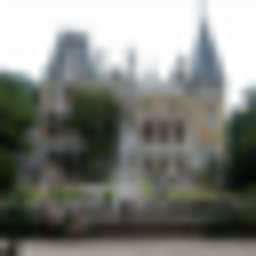

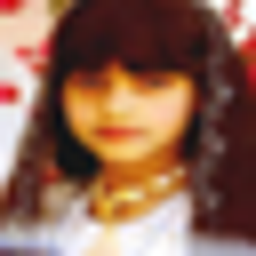

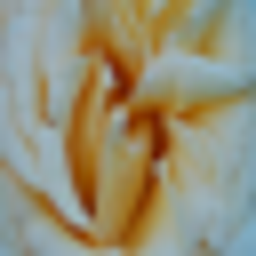

In [107]:
dataset_path = Path(stem_extensions(file_path))

with open(dataset_path / "train", "rb") as f:
    data_train = pickle.load(f, encoding="latin1")
with open(dataset_path / "test", "rb") as f:
    data_test = pickle.load(f, encoding="latin1")

# Классы по варианту.
CLASSES = [17, 70, 35]

train_X = data_train["data"].reshape(-1, 3, 32, 32)
train_X = np.transpose(train_X, [0, 2, 3, 1])  # NCHW -> NHWC
train_y = np.array(data_train["fine_labels"])
mask = np.isin(train_y, CLASSES)
train_X = train_X[mask].copy()
train_y = train_y[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test["data"].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test["fine_labels"])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test

# По экземпляру класса из выборки.
for class_index, _ in enumerate(CLASSES):  # Берём именно индексы, так как классы, которые мы выбрали, в итоге нормировались в 0, 1, 2.
    image_index_for_class = train_y.tolist().index(class_index)
    display(Image.fromarray(train_X[image_index_for_class]).resize((256, 256)))

### Создание Pytorch DataLoader'a

In [108]:
batch_size = 128
dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)], ["train", "test"]):
    tensor_x = torch.Tensor(X)
    tensor_y = (
        F.one_hot(torch.Tensor(y).to(torch.int64), num_classes=len(CLASSES)) / 1.0
    )
    dataset = TensorDataset(tensor_x, tensor_y)  # создание объекта датасета
    dataloader[part] = DataLoader(
        dataset, batch_size=batch_size, shuffle=True
    )  # создание экземпляра класса DataLoader
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x162c618d0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x162c61480>}

### Создание Pytorch модели многослойного перцептрона с одним скрытым слоем

In [109]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std

        return torch.flatten(x, start_dim=1)  # nhwc -> nm


class Cifar100_MLP(nn.Module):
    def __init__(self, hidden_size=32, classes=100):
        super(Cifar100_MLP, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.norm = Normalize([0.5074, 0.4867, 0.4411], [0.2011, 0.1987, 0.2025])
        self.seq = nn.Sequential(
            nn.Linear(32 * 32 * 3, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, classes),
        )

    def forward(self, input):
        x = self.norm(input)

        return self.seq(x)


HIDDEN_SIZE = 10
model = Cifar100_MLP(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
model

Cifar100_MLP(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=3, bias=True)
  )
)

### Выбор функции потерь и оптимизатора градиентного спуска

In [110]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

### Обучение модели по эпохам

In [111]:
EPOCHS = 250
steps_per_epoch = len(dataloader["train"])
steps_per_epoch_val = len(dataloader["test"])
for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    running_loss = 0.0
    model.train()
    for i, batch in enumerate(dataloader["train"], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        # для подсчёта статистик
        running_loss += loss.item()
    print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / steps_per_epoch:.3f}")
    running_loss = 0.0
    model.eval()
    with torch.no_grad():  # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader["test"], 0):
            inputs, labels = data

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    print(
        f"[{epoch + 1}, {i + 1:5d}] val loss: {running_loss / steps_per_epoch_val:.3f}"
    )
print("Обучение закончено")

[1,    12] loss: 0.981
[1,     3] val loss: 0.817
[2,    12] loss: 0.788
[2,     3] val loss: 0.707
[3,    12] loss: 0.708
[3,     3] val loss: 0.679
[4,    12] loss: 0.661
[4,     3] val loss: 0.622
[5,    12] loss: 0.627
[5,     3] val loss: 0.632
[6,    12] loss: 0.597
[6,     3] val loss: 0.565
[7,    12] loss: 0.575
[7,     3] val loss: 0.523
[8,    12] loss: 0.551
[8,     3] val loss: 0.541
[9,    12] loss: 0.536
[9,     3] val loss: 0.555
[10,    12] loss: 0.514
[10,     3] val loss: 0.488
[11,    12] loss: 0.501
[11,     3] val loss: 0.465
[12,    12] loss: 0.483
[12,     3] val loss: 0.453
[13,    12] loss: 0.469
[13,     3] val loss: 0.450
[14,    12] loss: 0.452
[14,     3] val loss: 0.437
[15,    12] loss: 0.443
[15,     3] val loss: 0.438
[16,    12] loss: 0.436
[16,     3] val loss: 0.455
[17,    12] loss: 0.424
[17,     3] val loss: 0.476
[18,    12] loss: 0.415
[18,     3] val loss: 0.451
[19,    12] loss: 0.408
[19,     3] val loss: 0.448
[20,    12] loss: 0.400
[20,  

[162,    12] loss: 0.083
[162,     3] val loss: 0.506
[163,    12] loss: 0.084
[163,     3] val loss: 0.471
[164,    12] loss: 0.082
[164,     3] val loss: 0.414
[165,    12] loss: 0.083
[165,     3] val loss: 0.498
[166,    12] loss: 0.080
[166,     3] val loss: 0.455
[167,    12] loss: 0.080
[167,     3] val loss: 0.440
[168,    12] loss: 0.079
[168,     3] val loss: 0.489
[169,    12] loss: 0.080
[169,     3] val loss: 0.547
[170,    12] loss: 0.077
[170,     3] val loss: 0.431
[171,    12] loss: 0.077
[171,     3] val loss: 0.512
[172,    12] loss: 0.077
[172,     3] val loss: 0.445
[173,    12] loss: 0.076
[173,     3] val loss: 0.478
[174,    12] loss: 0.074
[174,     3] val loss: 0.489
[175,    12] loss: 0.074
[175,     3] val loss: 0.461
[176,    12] loss: 0.073
[176,     3] val loss: 0.457
[177,    12] loss: 0.072
[177,     3] val loss: 0.511
[178,    12] loss: 0.072
[178,     3] val loss: 0.420
[179,    12] loss: 0.071
[179,     3] val loss: 0.477
[180,    12] loss: 0.070
[18

### Проверка качества модели по классам на обучающей и тестовой выборках

In [112]:
for part in ["train", "test"]:
    y_pred = []
    y_true = []
    with torch.no_grad():  # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data

            outputs = model(inputs).detach().numpy()
            y_pred.append(outputs)
            y_true.append(labels.numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(part)
        print(
            classification_report(
                y_true.argmax(axis=-1),
                y_pred.argmax(axis=-1),
                digits=4,
                target_names=list(map(str, CLASSES)),
            )
        )
        print("-" * 50)

train
              precision    recall  f1-score   support

          17     0.9980    0.9960    0.9970       500
          70     0.9980    0.9960    0.9970       500
          35     0.9960    1.0000    0.9980       500

    accuracy                         0.9973      1500
   macro avg     0.9973    0.9973    0.9973      1500
weighted avg     0.9973    0.9973    0.9973      1500

--------------------------------------------------
test
              precision    recall  f1-score   support

          17     0.9314    0.9500    0.9406       100
          70     0.8434    0.7000    0.7650       100
          35     0.7565    0.8700    0.8093       100

    accuracy                         0.8400       300
   macro avg     0.8438    0.8400    0.8383       300
weighted avg     0.8438    0.8400    0.8383       300

--------------------------------------------------


### Визуализация весов

(10, 3072)


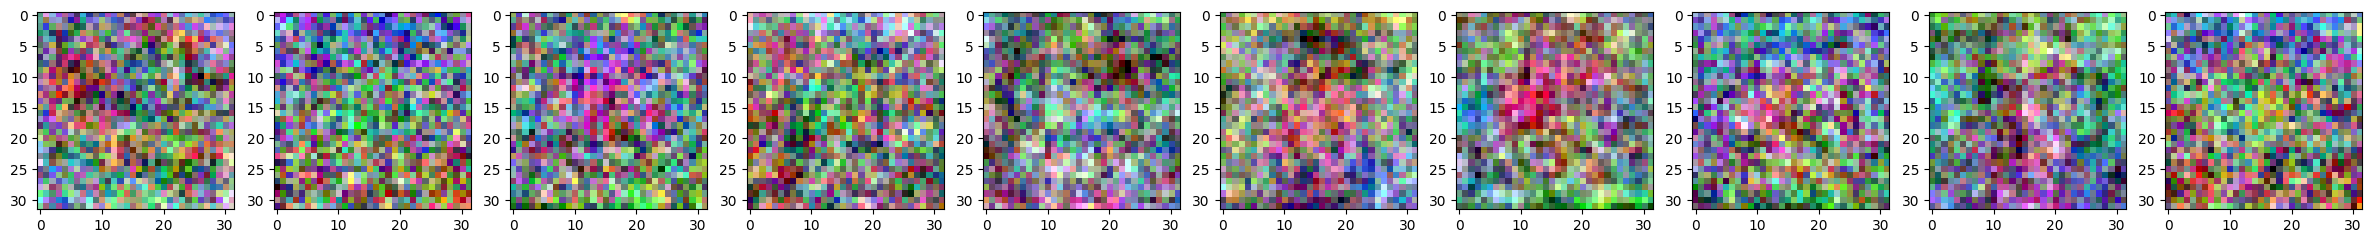

In [113]:
weights = list(model.parameters())[0].detach().numpy()
print(weights.shape)
fig, ax = plt.subplots(1, weights.shape[0], figsize=(3 * weights.shape[0], 3))
for i, ω in enumerate(weights):
    ω = ω.reshape(32, 32, 3)
    ω -= np.percentile(ω, 1, axis=[0, 1])
    ω /= np.percentile(ω, 99, axis=[0, 1])
    ω = np.clip(ω, 0, 1)
    ax[i].imshow(ω)